In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install scapy

In [2]:
train_df = pd.read_csv("Mar-29-2021.csv", index_col=0)
train_df.head()

Implementation    Mode  \
Run                                                              
0     ./server -d . -c /QUIC-Ivy/doc/examples/quic/...  server   
1     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   
2     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   
3     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   
4     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   

                     TestName  Status                ErrorIEV  \
Run                                                             
0    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
1    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
2    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
3    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
4    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   

                                         OutputFile  NbPktSend  isPass  
Run                                                                     
0    /results/temp/355/quic_server_test_stream0.iev        0.0     0.0  
1    /results/temp/405/quic_server_test_stream0.iev        0.0     0.0  
2    /results/temp/406/quic_server_test_stream0.iev        0.0     0.0  
3    /results/temp/456/quic_server_test_stream0.iev        0.0     0.0  
4    /results/temp/457/quic_server_test_stream0.iev        0.0     0.0

In [3]:
server_name = train_df.Implementation.unique()
servers = []
for s in server_name:
    if "cargo run" in s:
        servers.append("quinn")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quinn")
    if "./http_server" in s:
        servers.append("lsquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "lsquic")
    if "./picoquicdemo" in s:
        servers.append("picoquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "picoquic")
    if "./server -d" in s:
        servers.append("quant")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quant")
    if "./server -c" in s:
        servers.append("quic-go")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quic-go")
    if "python3" in s:
        servers.append("aioquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "aioquic")
    if "echo" in s:
        servers.append("mvfst")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "mvfst")
        
print(servers)
train_df["isPass"] = train_df["isPass"].replace(0.0, 0)
train_df["isPass"] = train_df["isPass"].replace(1.0, 1)
train_df.head()

['quant', 'quic-go', 'aioquic', 'quinn', 'mvfst', 'picoquic']


Implementation    Mode                  TestName  Status  \
Run                                                            
0            quant  server  quic_server_test_stream0     NaN   
1          quic-go  server  quic_server_test_stream0     NaN   
2          quic-go  server  quic_server_test_stream0     NaN   
3          quic-go  server  quic_server_test_stream0     NaN   
4          quic-go  server  quic_server_test_stream0     NaN   

                   ErrorIEV                                      OutputFile  \
Run                                                                           
0    ivy_return_code(1)+"")  /results/temp/355/quic_server_test_stream0.iev   
1    ivy_return_code(1)+"")  /results/temp/405/quic_server_test_stream0.iev   
2    ivy_return_code(1)+"")  /results/temp/406/quic_server_test_stream0.iev   
3    ivy_return_code(1)+"")  /results/temp/456/quic_server_test_stream0.iev   
4    ivy_return_code(1)+"")  /results/temp/457/quic_server_test_stream0.iev   

     NbPktSend  isPass  
Run                     
0          0.0     0.0  
1          0.0     0.0  
2          0.0     0.0  
3          0.0     0.0  
4          0.0     0.0

In [12]:

for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = "server-result-2" + row["OutputFile"][8:]
        f = open(resultFile, "r")
        content = f.read()
        if "frame.connection_close:" in content:
            start_index = content.find("frame.connection_close:")
            end_index = content.find("}",start_index)
            train_df.loc[i, "ErrorIEV"] = content[start_index:end_index+1]
        elif "Run out of cid" in content:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif "ivy_return_code(139)" in content:
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault"
        elif content.count("tls_recv_event") > 10:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed"
    else:
        train_df.loc[i, "ErrorIEV"] = "No Error"
                        
train_df.head()

Implementation    Mode                  TestName  Status  \
Run                                                            
0            quant  server  quic_server_test_stream0     NaN   
1          quic-go  server  quic_server_test_stream0     NaN   
2          quic-go  server  quic_server_test_stream0     NaN   
3          quic-go  server  quic_server_test_stream0     NaN   
4          quic-go  server  quic_server_test_stream0     NaN   

                    ErrorIEV                                      OutputFile  \
Run                                                                            
0    Handshake not completed  /results/temp/355/quic_server_test_stream0.iev   
1    Handshake not completed  /results/temp/405/quic_server_test_stream0.iev   
2    Handshake not completed  /results/temp/406/quic_server_test_stream0.iev   
3    Handshake not completed  /results/temp/456/quic_server_test_stream0.iev   
4    Handshake not completed  /results/temp/457/quic_server_test_stream0.iev   

     NbPktSend  isPass  
Run                     
0         23.0     0.0  
1         16.0     0.0  
2          8.0     0.0  
3         14.0     0.0  
4         14.0     0.0

In [13]:
train_df.head(100)

Implementation    Mode                       TestName  Status  \
Run                                                                 
0            quant  server       quic_server_test_stream0     NaN   
1          quic-go  server       quic_server_test_stream0     NaN   
2          quic-go  server       quic_server_test_stream0     NaN   
3          quic-go  server       quic_server_test_stream0     NaN   
4          quic-go  server       quic_server_test_stream0     NaN   
5          aioquic  server       quic_server_test_stream0     NaN   
6          aioquic  server       quic_server_test_stream0     NaN   
7          aioquic  server       quic_server_test_stream0     NaN   
8          aioquic  server       quic_server_test_stream0     NaN   
9            quinn  server                            NaN     NaN   
10           quinn  server                            NaN     NaN   
11           quinn  server                            NaN     NaN   
12           quinn  server                            NaN     NaN   
13           mvfst  server                            NaN     NaN   
14           mvfst  server                            NaN     NaN   
15           mvfst  server                            NaN     NaN   
16        picoquic  server                            NaN     NaN   
17        picoquic  server                            NaN     NaN   
18           quant  server                            NaN     NaN   
19           quant  server                            NaN     NaN   
20           quant  server                            NaN     NaN   
21         quic-go  server                            NaN     NaN   
22         quic-go  server                            NaN     NaN   
23         quic-go  server                            NaN     NaN   
24         quic-go  server                            NaN     NaN   
25         aioquic  server                            NaN     NaN   
26         aioquic  server                            NaN     NaN   
27         aioquic  server                            NaN     NaN   
28         aioquic  server                            NaN     NaN   
29           quinn  server                            NaN     NaN   
..             ...     ...                            ...     ...   
70         quic-go  server          quic_server_test_max0     NaN   
71         quic-go  server          quic_server_test_max0     NaN   
72         quic-go  server          quic_server_test_max0     NaN   
73         aioquic  server          quic_server_test_max0     NaN   
74         aioquic  server          quic_server_test_max0     NaN   
75         aioquic  server          quic_server_test_max0     NaN   
76         aioquic  server          quic_server_test_max0     NaN   
77           quinn  server  quic_server_test_token_error0     NaN   
78           quinn  server  quic_server_test_token_error0     NaN   
79           quinn  server  quic_server_test_token_error0     NaN   
80           quinn  server  quic_server_test_token_error0     NaN   
81           mvfst  server  quic_server_test_token_error0     NaN   
82           mvfst  server  quic_server_test_token_error0     NaN   
83           mvfst  server  quic_server_test_token_error0     NaN   
84           mvfst  server  quic_server_test_token_error0     NaN   
85        picoquic  server  quic_server_test_token_error0     NaN   
86        picoquic  server  quic_server_test_token_error0     NaN   
87        picoquic  server  quic_server_test_token_error0     NaN   
88        picoquic  server  quic_server_test_token_error0     NaN   
89           quant  server  quic_server_test_token_error0     NaN   
90           quant  server  quic_server_test_token_error0     NaN   
91           quant  server  quic_server_test_token_error0     NaN   
92           quant  server  quic_server_test_token_error0     NaN   
93         quic-go  server  quic_server_test_token_error0     NaN   
94         quic-go  server  quic_server_test_token_error0     NaN   
95

In [8]:
train_df.TestName.unique()


array(['quic_server_test_stream0', nan, 'quic_server_test_max0',
       'quic_server_test_token_error0', 'quic_server_test_tp_error0',
       'quic_server_test_tp_acticoid_error0',
       'quic_server_test_connection_close0',
       'quic_server_test_reset_stream0',
       'quic_server_test_retirecoid_error0',
       'quic_server_test_newcoid_zero_error0',
       'quic_server_test_handshake_done_error0',
       'quic_server_test_stop_sending0',
       'quic_server_test_double_tp_error0',
       'quic_server_test_tp_limit_acticoid_error0',
       'quic_server_test_accept_maxdata0'], dtype=object)

In [ ]:
from scapy.all import *
import threading
import multiprocessing

# splitting dataframe by row index 
total_rows = train_df.shape[0]
print(total_rows)
cnt  = 10 #multiprocessing.cpu_count()
size = total_rows / cnt
size = int(size)
print(size)
list_of_dfs = [train_df.loc[i:i+size-1,:] for i in range(0, len(train_df),size)]
print(len(list_of_dfs))
print()
j = 0


def process_pkt(df):
    for index, row in df.iterrows():
        outfile = row["OutputFile"]
        if "iev" in row["OutputFile"] :
            i =  row["OutputFile"][outfile.find("/",13)+1:outfile.find("/",14)] 
            if isinstance(row["TestName"],str) and not row["TestName"] == np.nan :
                resultFile = "temp/" + str(i) + "_quic_server_" + str(row["TestName"][:-1]) + ".pcap"
                packets = rdpcap(resultFile)
                ln = len(packets)
                df.loc[index, "NbPktSend"] = ln
    
        
for index in range(cnt):
    process_pkt(list_of_dfs[index])
    toPrint = (j/size) * 10
    print(str(toPrint) + "% Processed")
    train_df.to_csv(path_or_buf="server2_processed.csv",index=False)
    j += size
    

train_df.head()

10800
1080
10

0.0% Processed
10.0% Processed
20.0% Processed
30.0% Processed
40.0% Processed
50.0% Processed
60.0% Processed
70.0% Processed


In [ ]:
train_df["ErrorOUT"] = ""
train_df["ErrorERR"] = ""
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = "server_result" + row["OutputFile"][8:]
        resultFile = resultFile.replace(".iev",".out")
        f = open(resultFile, "r")
        content = f.read()
        content = content.lower()
        if "error" in content:
            start_index = content.find("error")
            start_index = content.find("\n",start_index)
            end_index   = content.find("\n",start_index)
            train_df.loc[i, "ErrorOUT"] = content[start_index:end_index+1]
        resultFile = resultFile.replace(".iev",".err")
        f = open(resultFile, "r")
        content = f.read()
        content = content.lower()
        if "error" in content:
            start_index = content.find("error")
            start_index = content.find("\n",start_index)
            end_index   = content.find("\n",start_index)
            train_df.loc[i, "ErrorERR"] = content[start_index:end_index+1]
                        
train_df.head()

In [ ]:
train_df.to_csv(path_or_buf="server_processed.csv",index=False)

Text(0, 0.5, 'Average Accuracy')

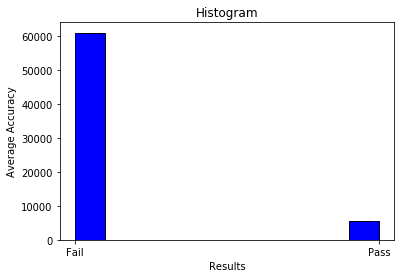

In [9]:
# matplotlib histogram

x = ["Pass","Fail"]

cnt = train_df['isPass'].value_counts()

plt.hist(train_df['isPass'], color = ['blue'], edgecolor = 'black')

# seaborn histogram
sns.distplot(train_df['isPass'], hist=True, kde=False, 
             color = ['blue'])

plt.xticks(np.arange(0, 2, 1))
positions = (0, 1)
labels = ("Fail", "Pass")
plt.xticks(positions, labels)
# Add labels
plt.title('Histogram')
plt.xlabel('Number of test passed')
plt.ylabel('Count')

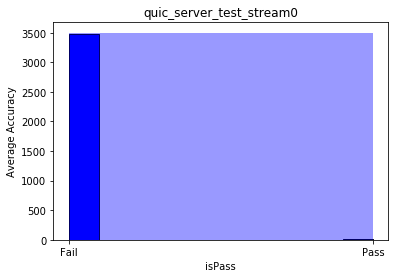

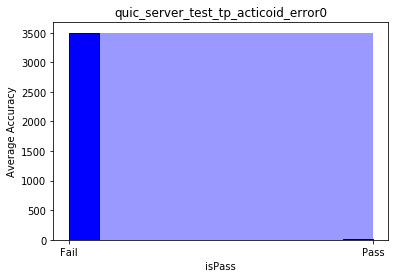

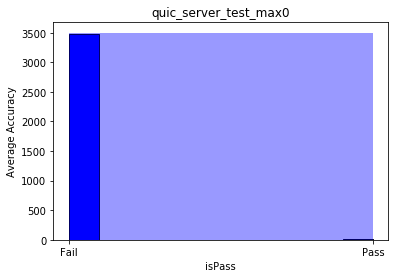

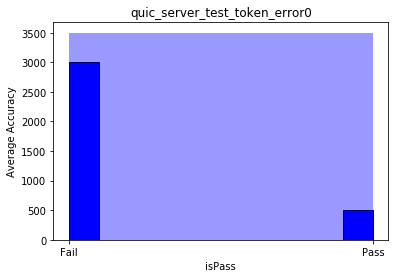

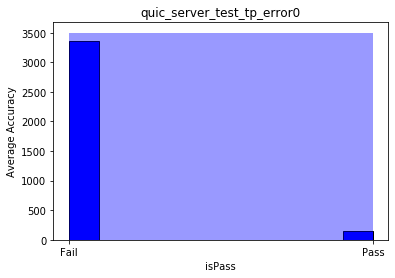

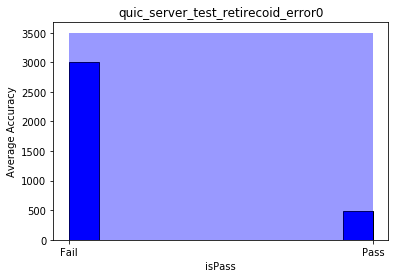

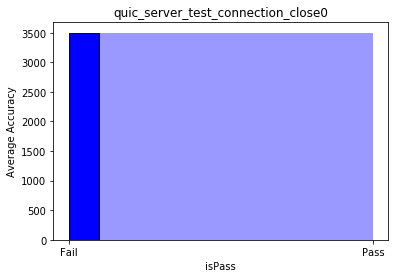

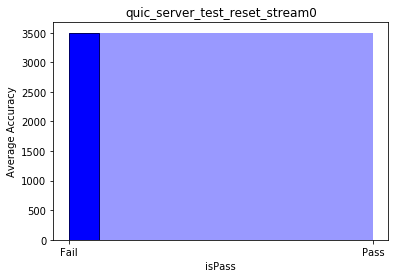

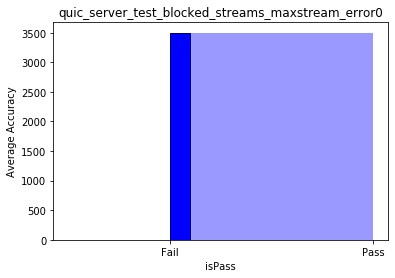

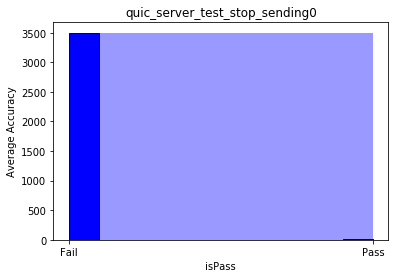

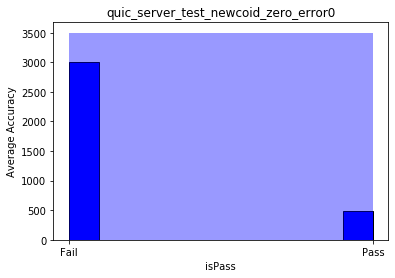

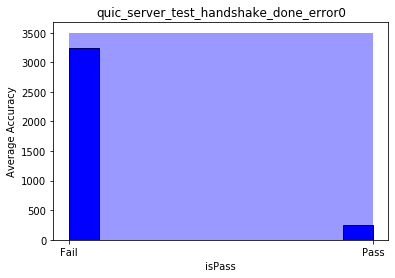

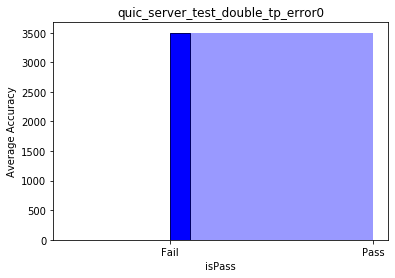

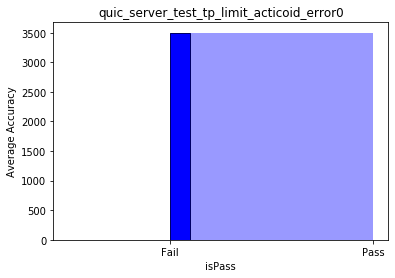

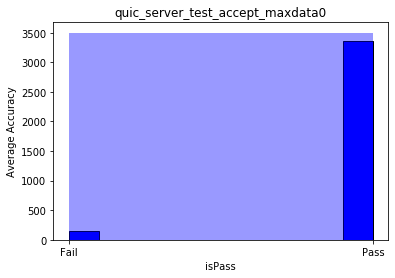

In [89]:
# Failure per test

train_df.TestName.unique()
tests = ['quic_server_test_stream0', 
       'quic_server_test_tp_acticoid_error0', 'quic_server_test_max0',
       'quic_server_test_token_error0', 'quic_server_test_tp_error0',
       'quic_server_test_retirecoid_error0',
       'quic_server_test_connection_close0',
       'quic_server_test_reset_stream0',
       'quic_server_test_blocked_streams_maxstream_error0',
       'quic_server_test_stop_sending0',
       'quic_server_test_newcoid_zero_error0',
       'quic_server_test_handshake_done_error0',
       'quic_server_test_double_tp_error0',
       'quic_server_test_tp_limit_acticoid_error0',
       'quic_server_test_accept_maxdata0']

#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.distplot(subdf['isPass'], hist=True, kde=False, 
                 color = 'blue',bins=[0, 1])
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('Average Accuracy')
    plt.show()
    

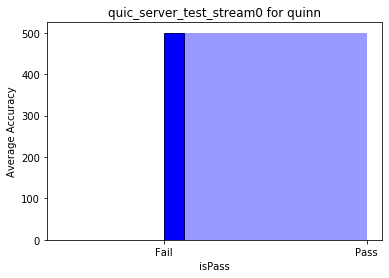

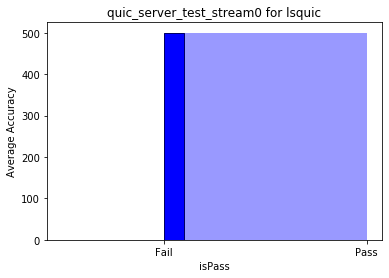

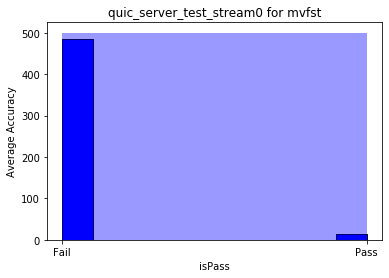

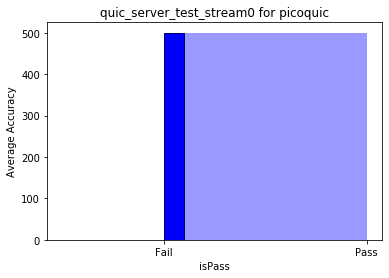

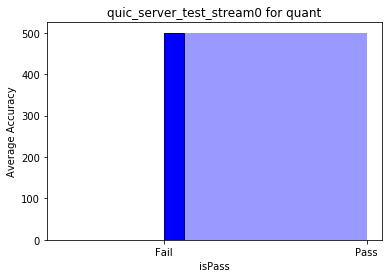

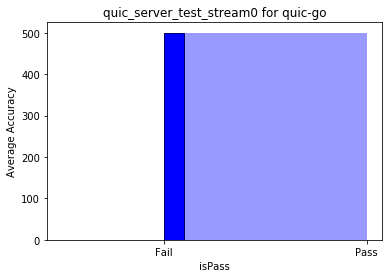

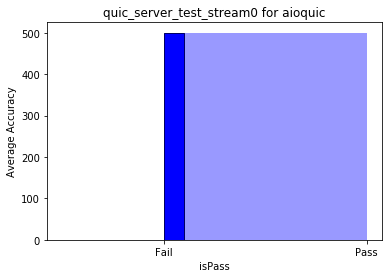

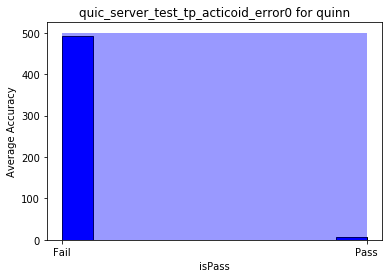

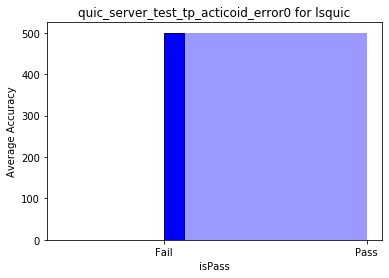

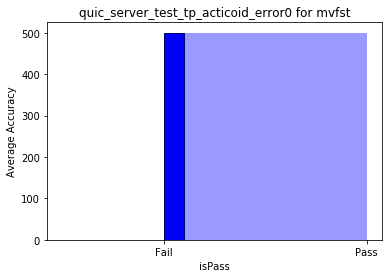

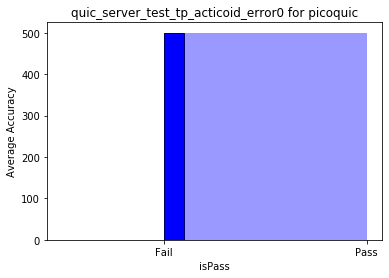

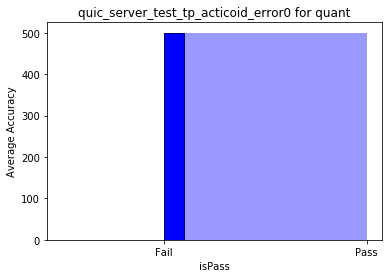

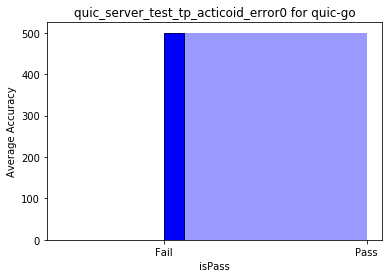

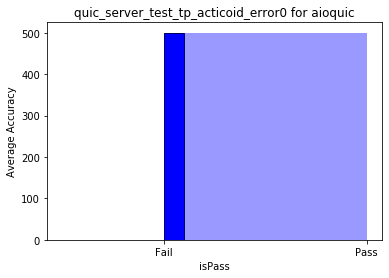

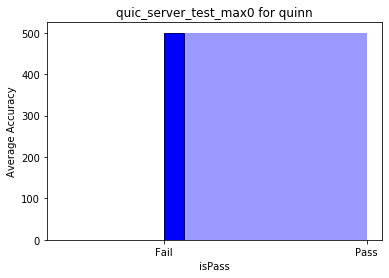

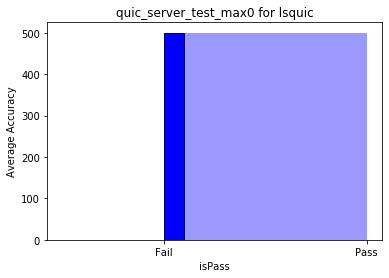

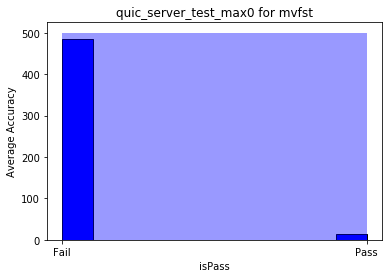

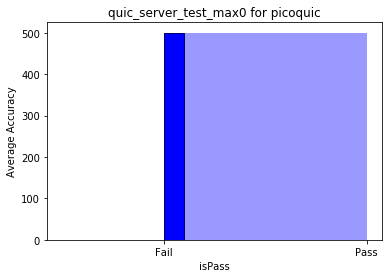

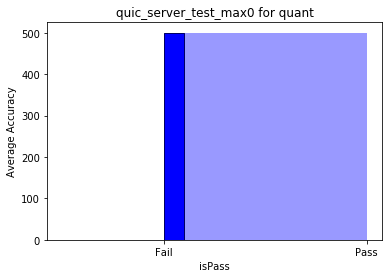

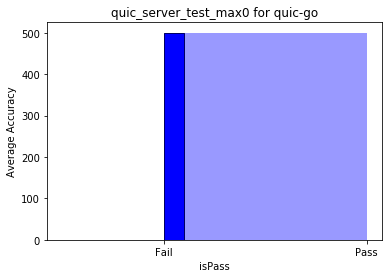

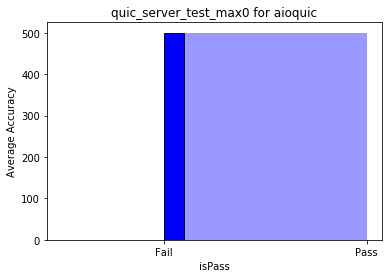

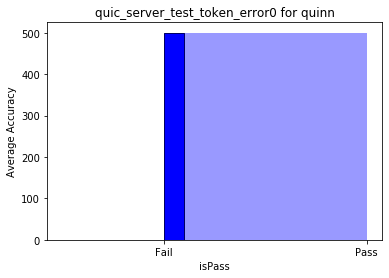

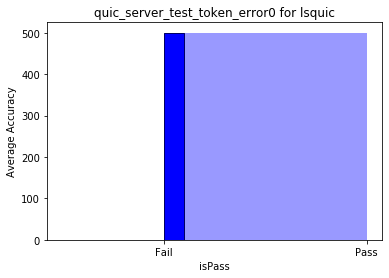

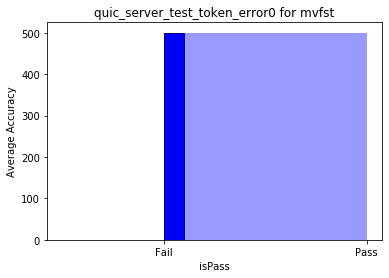

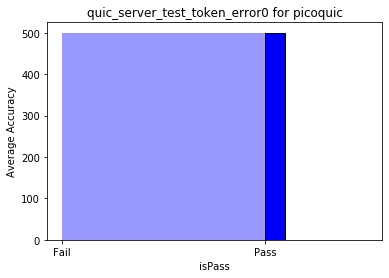

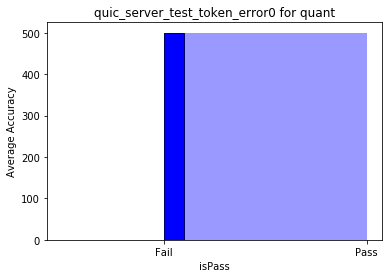

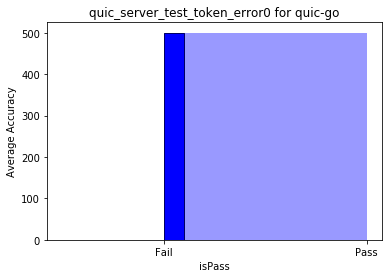

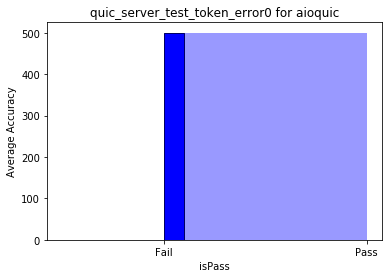

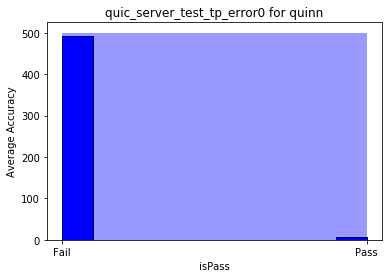

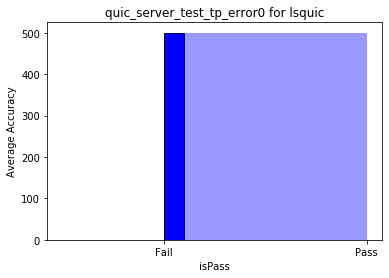

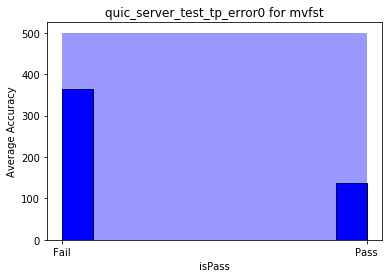

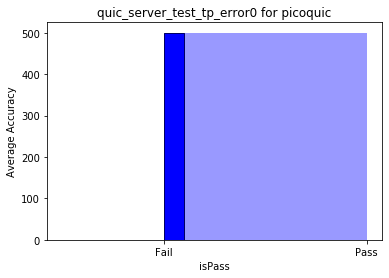

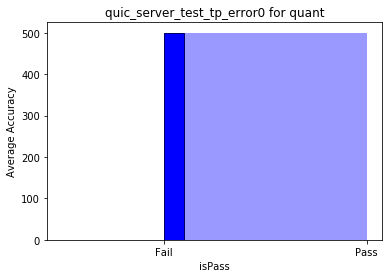

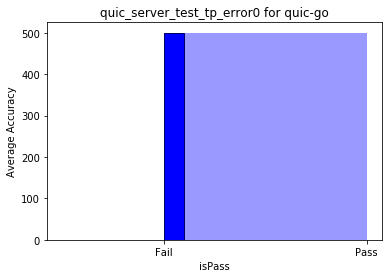

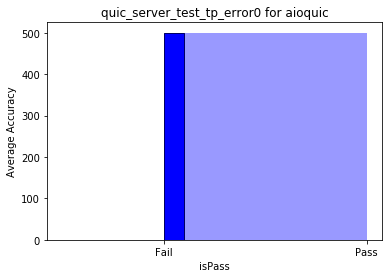

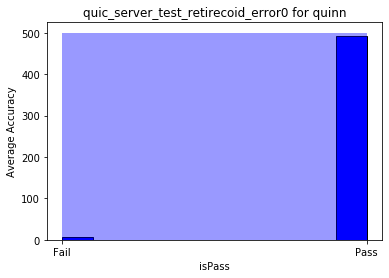

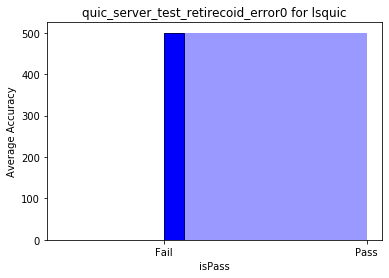

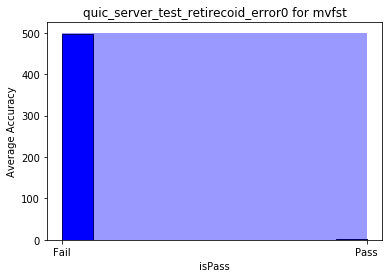

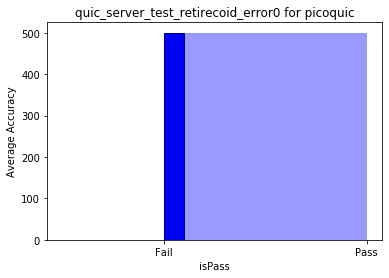

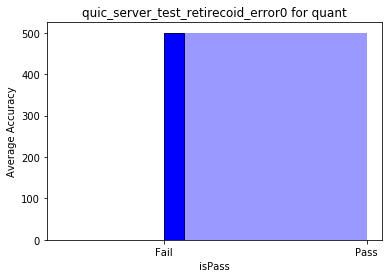

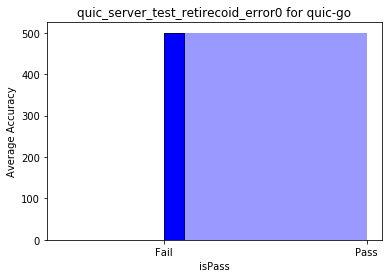

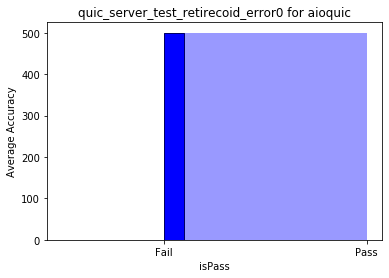

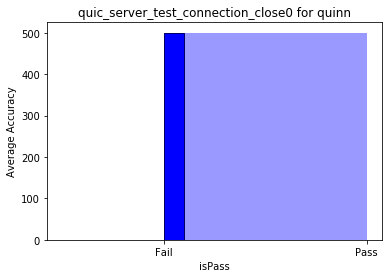

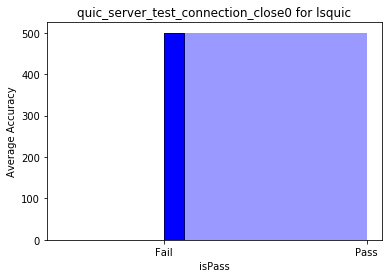

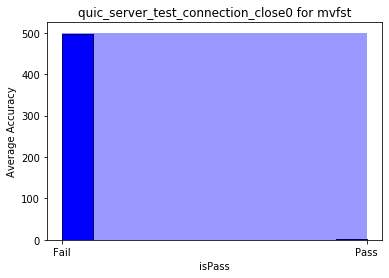

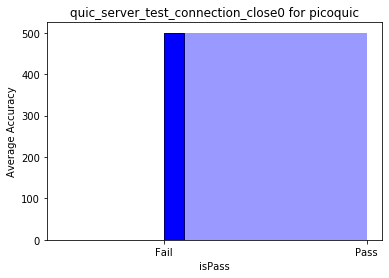

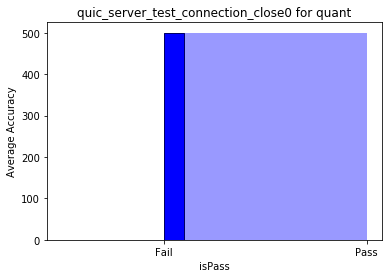

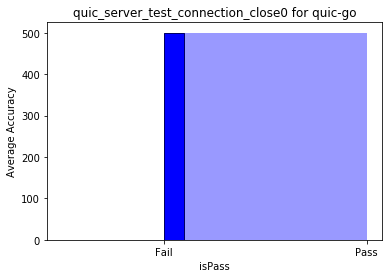

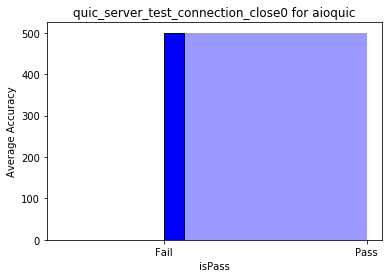

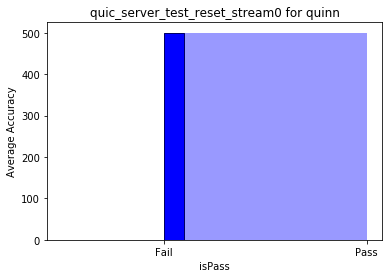

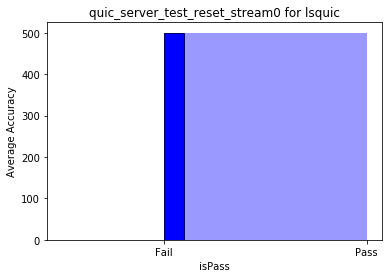

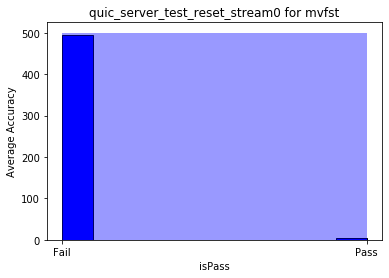

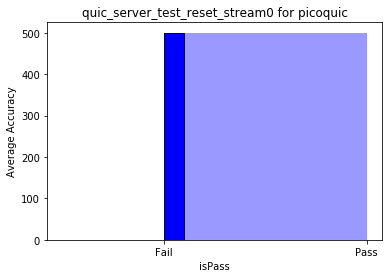

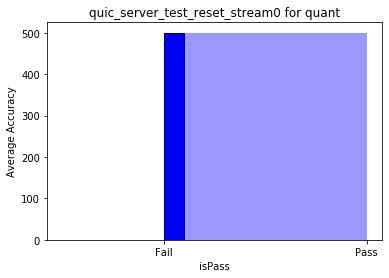

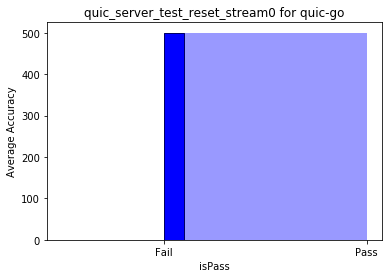

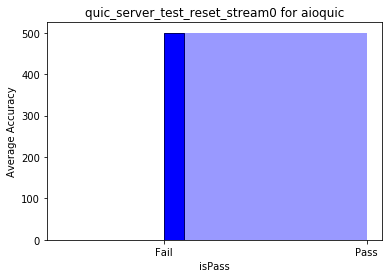

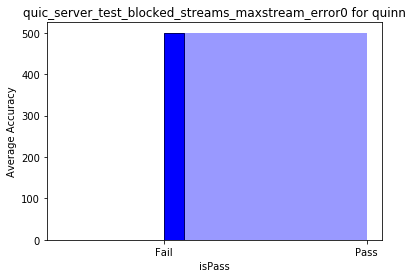

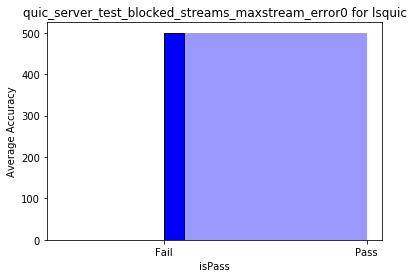

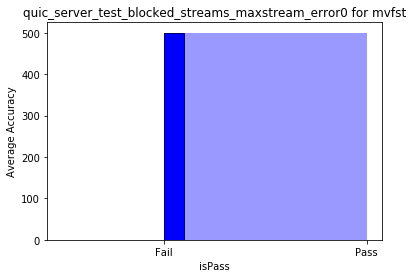

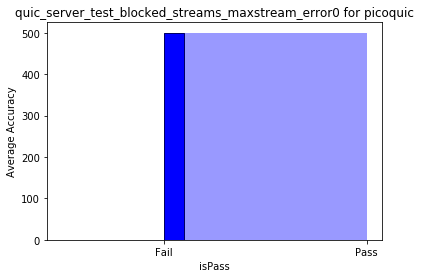

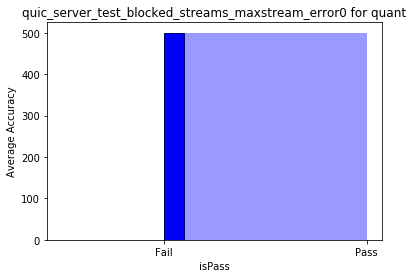

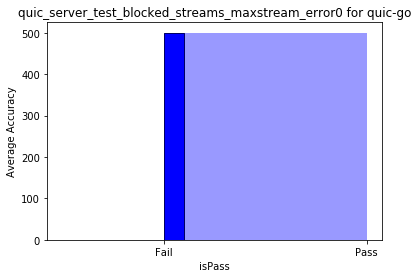

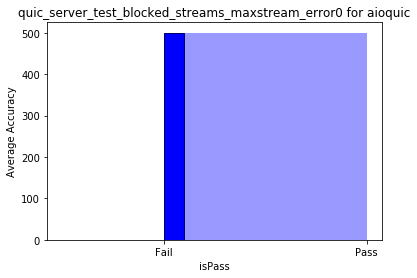

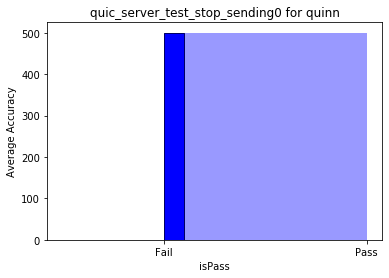

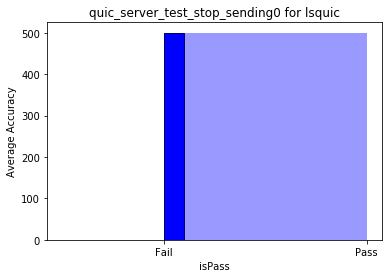

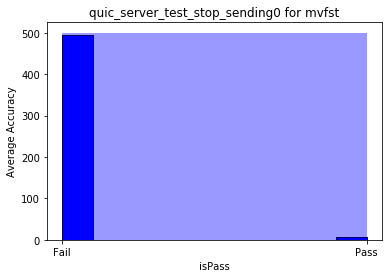

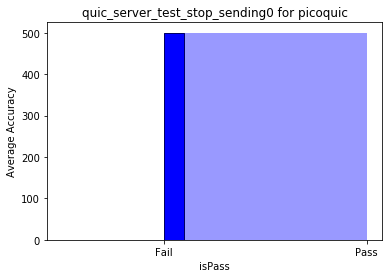

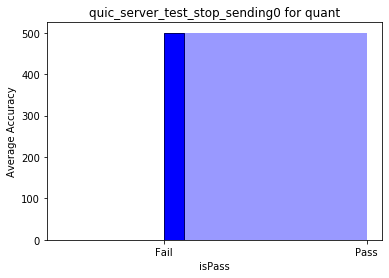

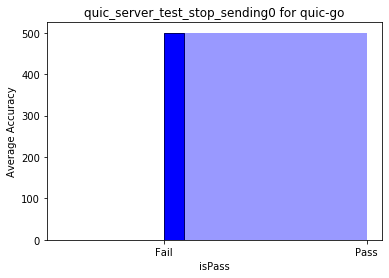

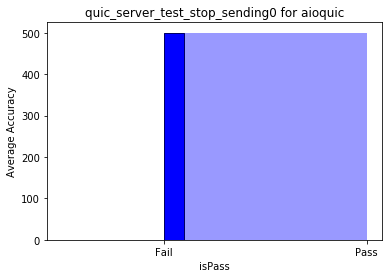

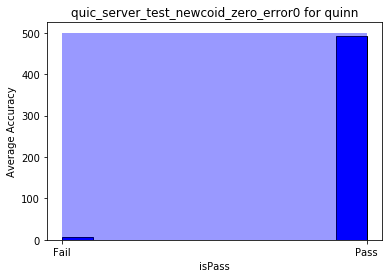

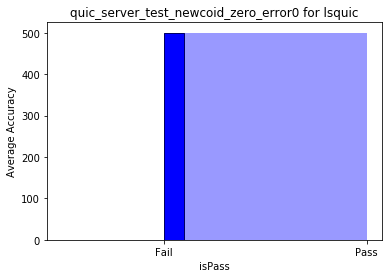

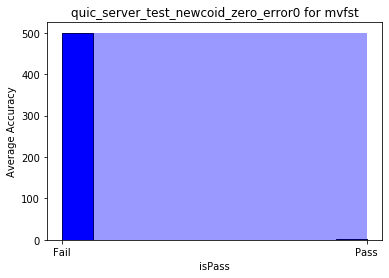

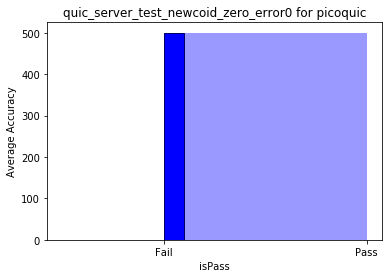

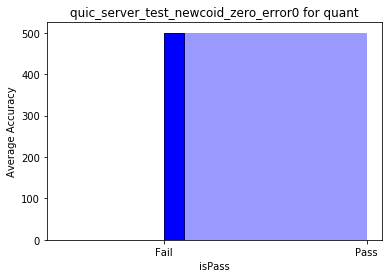

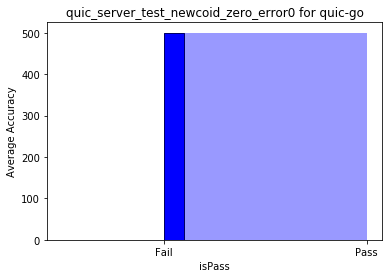

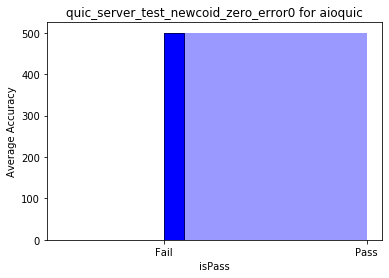

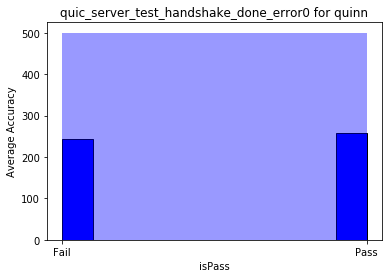

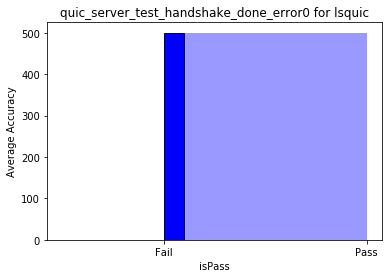

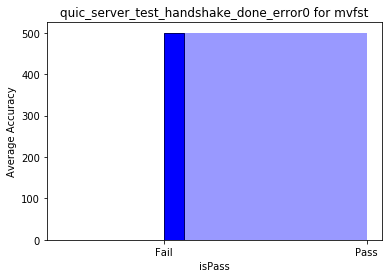

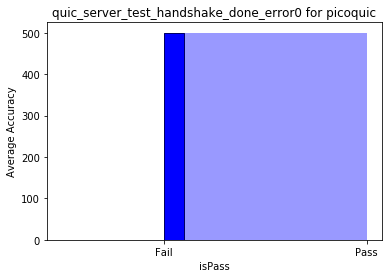

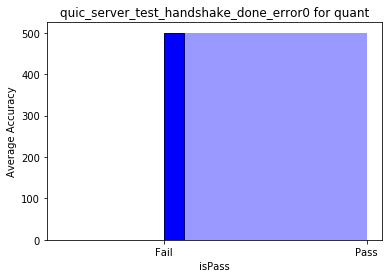

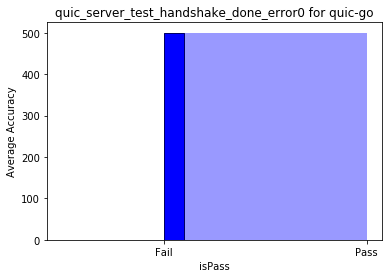

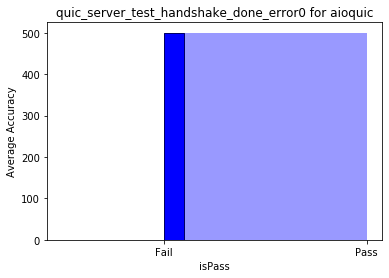

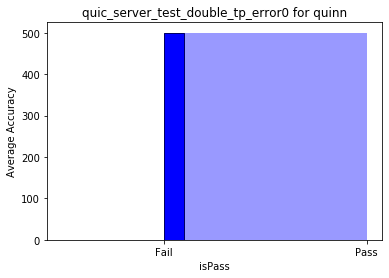

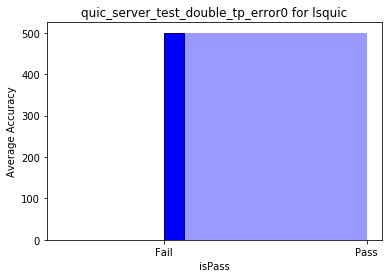

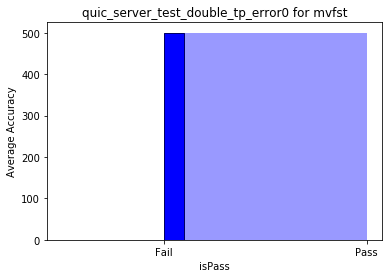

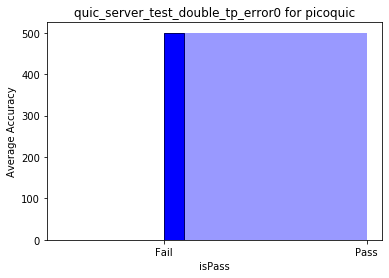

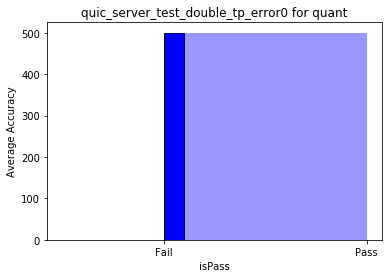

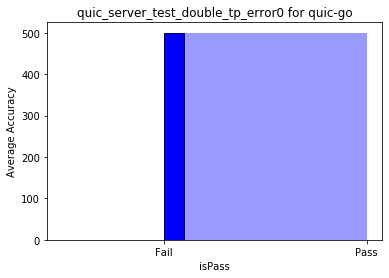

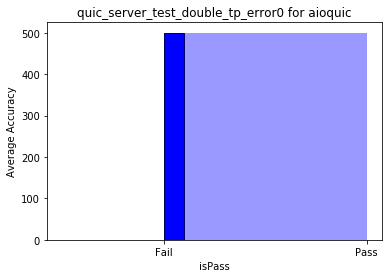

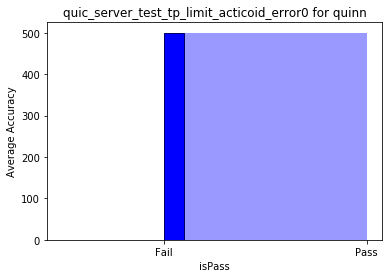

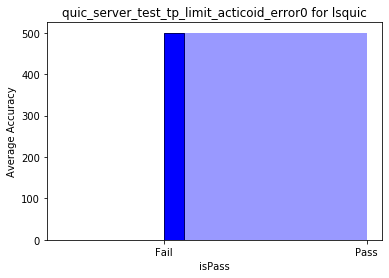

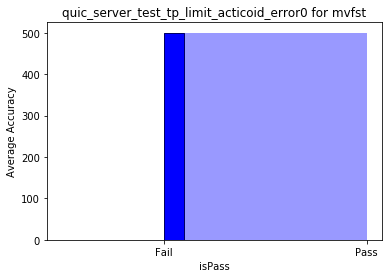

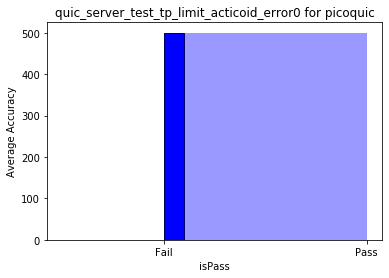

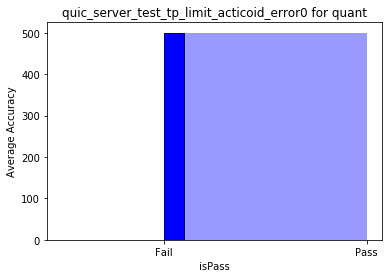

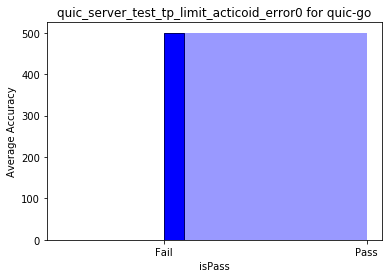

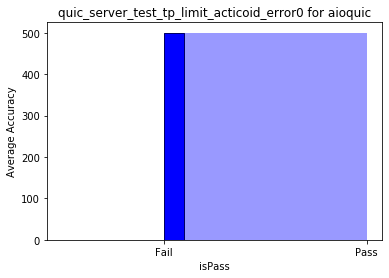

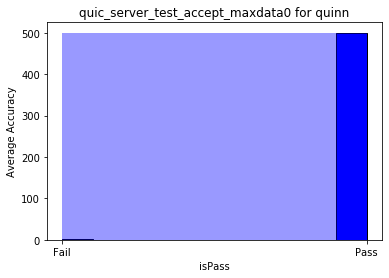

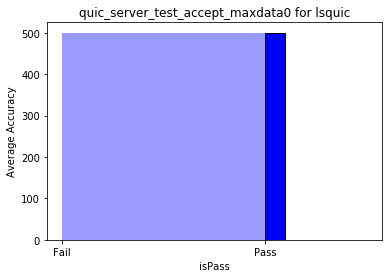

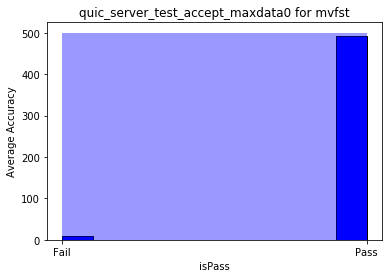

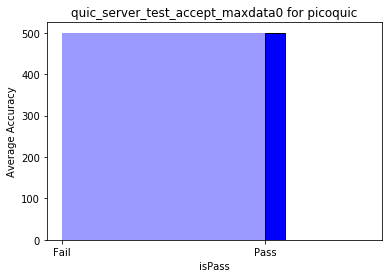

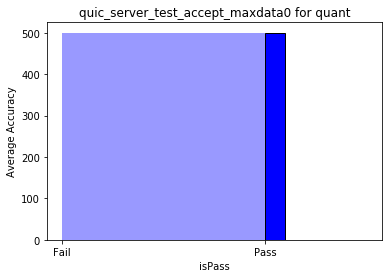

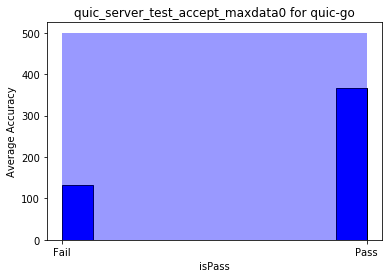

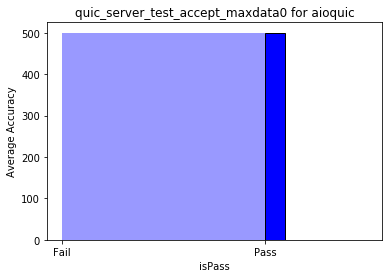

In [92]:
# Failure per test and per implementation

train_df.Implementation.unique()
tests = ['quic_server_test_stream0', 
       'quic_server_test_tp_acticoid_error0', 'quic_server_test_max0',
       'quic_server_test_token_error0', 'quic_server_test_tp_error0',
       'quic_server_test_retirecoid_error0',
       'quic_server_test_connection_close0',
       'quic_server_test_reset_stream0',
       'quic_server_test_blocked_streams_maxstream_error0',
       'quic_server_test_stop_sending0',
       'quic_server_test_newcoid_zero_error0',
       'quic_server_test_handshake_done_error0',
       'quic_server_test_double_tp_error0',
       'quic_server_test_tp_limit_acticoid_error0',
       'quic_server_test_accept_maxdata0']

servers = ['quinn', 'lsquic', 'mvfst', 'picoquic', 'quant', 'quic-go', 'aioquic']
#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        plt.hist(subsubdf['isPass'], color = 'blue', edgecolor = 'black')

        # seaborn histogram
        sns.distplot(subsubdf['isPass'], hist=True, kde=False, 
                     color = 'blue',bins=[0, 1])
        # Add labels
        plt.xticks(np.arange(0, 1, 1))
        positions = (0, 1)
        labels = ("Fail", "Pass")
        plt.xticks(positions, labels)
        plt.title(t + " for " + s)
        plt.xlabel('isPass')
        plt.ylabel('Average Accuracy')
        plt.show()
    

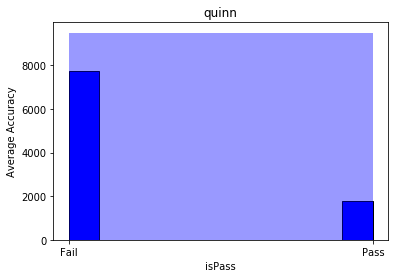

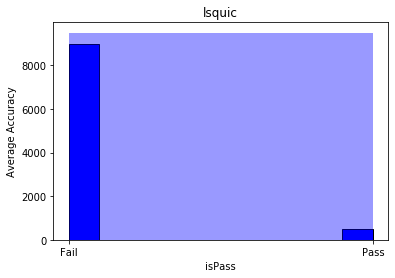

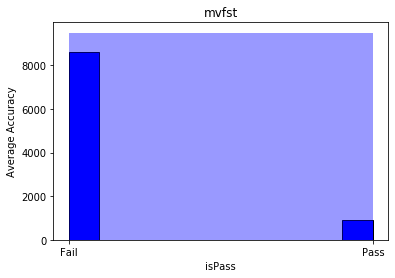

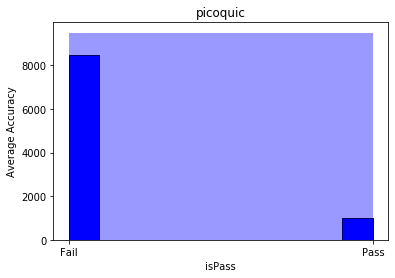

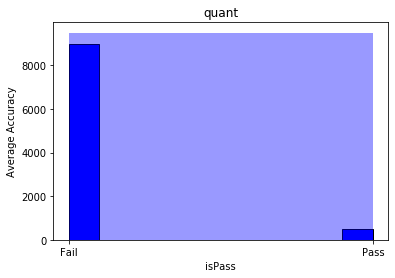

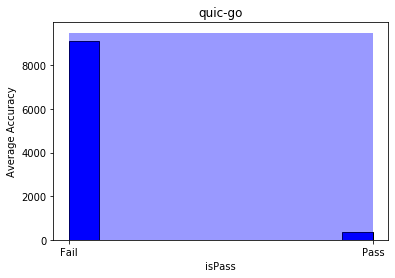

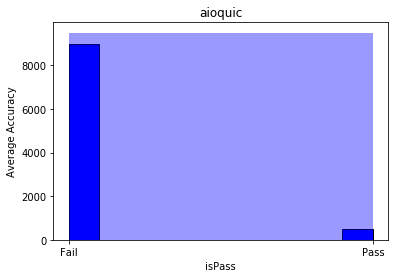

In [93]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.distplot(subdf['isPass'], hist=True, kde=False, 
                 color = 'blue',bins=[0, 1])
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('Average Accuracy')
    plt.show()
    